In [1]:
# Install a pip package in the current Jupyter kernel
# https://jakevdp.github.io/blog/2017/12/05/installing-python-packages-from-jupyter/
import sys
!{sys.executable} -m pip install tqdm

You are using pip version 10.0.1, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [1]:
import os,sys
import h5py
import pandas as pd
import numpy as np
from keras.preprocessing.image import ImageDataGenerator,array_to_img, img_to_array, load_img
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras import applications
import matplotlib.pyplot as plt
import seaborn as sns
import math
%matplotlib inline
from tqdm import tqdm
from PIL import Image

Using TensorFlow backend.


In [2]:
datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=False,
        fill_mode='nearest')

#generator=datagen.flow_from_directory('parking_image/train2', batch_size=1, save_to_dir= 'adsfpreview', save_format='jpg')

In [3]:
import os
directory = 'parking_image/mix/'

for filename in os.listdir(directory):
    if filename.endswith(".jpg"):
        #print(filename)
        img = load_img(os.path.join(directory,filename))
        x = img_to_array(img)  # this is a Numpy array with shape (3, 150, 150)
        x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, 150, 150)
        # the .flow() command below generates batches of randomly transformed images
        # and saves the results to the `preview/` directory
        i = 0
        for batch in datagen.flow(x, batch_size=1, save_to_dir='gen_images', save_prefix='cat', save_format='jpeg'):
            i += 1
            if i > 5: # this will set how many images are generated for each image "ingested"
                break  # otherwise the generator would loop indefinitely

## Convert the annotations into csv

In [4]:
import os
import glob
import pandas as pd
import xml.etree.ElementTree as ET


def xml_to_csv(path):
    xml_list = []
    for xml_file in glob.glob(path + '/*.xml'):
        tree = ET.parse(xml_file)
        root = tree.getroot()
        for member in root.findall('object'):
            value = (root.find('filename').text,
                     int(root.find('size')[0].text),
                     int(root.find('size')[1].text),
                     member[0].text,
                     int(member[4][0].text),
                     int(member[4][1].text),
                     int(member[4][2].text),
                     int(member[4][3].text)
                     )
            xml_list.append(value)
    column_name = ['filename', 'width', 'height', 'class', 'xmin', 'ymin', 'xmax', 'ymax']
    xml_df = pd.DataFrame(xml_list, columns=column_name)
    return xml_df

In [26]:
#image_path = os.path.join(os.getcwd(), 'annotations')
for directory in ['train','test']:
    image_path = os.path.join(os.getcwd(), 'images/{}'.format(directory))
    xml_df = xml_to_csv(image_path)
    xml_df.to_csv('data/{}_labels.csv'.format(directory), index=None)


print('Successfully converted xml to csv.')

Successfully converted xml to csv.


In [ ]:
# need to split the images above into test and train data sets
# this is required 

## Convert csv to TFrecord

In [8]:
"""
Usage:
  # From tensorflow/models/
  # Create train data:
  python generate_tfrecord.py --csv_input=data/train_labels.csv  --output_path=train.record

  # Create test data:
  python generate_tfrecord.py --csv_input=data/test_labels.csv  --output_path=test.record
"""
from __future__ import division
from __future__ import print_function
from __future__ import absolute_import

import os
import io
import pandas as pd
import tensorflow as tf

from PIL import Image
from object_detection.utils import dataset_util
from collections import namedtuple, OrderedDict

In [9]:
flags = tf.app.flags
flags.DEFINE_string('csv_input', '', 'Path to the CSV input')
flags.DEFINE_string('output_path', '', 'Path to output TFRecord')
flags.DEFINE_string('image_dir', '', 'Path to images')
FLAGS = flags.FLAGS

In [27]:


# TO-DO replace this with label map
def class_text_to_int(row_label):
    if row_label == '1P':
        return 1
    elif row_label == '2P':
        return 2
    elif row_label == 'no_standing':
        return 3
    elif row_label == '2p_disabled':
        return 4
    elif row_label == 'bus_zone':
        return 5
    elif row_label == 'one_way':
        return 6
    elif row_label == 'loading_zone':
        return 7
    else:
        None


def split(df, group):
    data = namedtuple('data', ['filename', 'object'])
    gb = df.groupby(group)
    return [data(filename, gb.get_group(x)) for filename, x in zip(gb.groups.keys(), gb.groups)]


def create_tf_example(group, path):
    with tf.gfile.GFile(os.path.join(path, '{}'.format(group.filename)), 'rb') as fid:
        encoded_jpg = fid.read()
    encoded_jpg_io = io.BytesIO(encoded_jpg)
    image = Image.open(encoded_jpg_io)
    width, height = image.size

    filename = group.filename.encode('utf8')
    image_format = b'jpg'
    xmins = []
    xmaxs = []
    ymins = []
    ymaxs = []
    classes_text = []
    classes = []

    for index, row in group.object.iterrows():
        xmins.append(row['xmin'] / width)
        xmaxs.append(row['xmax'] / width)
        ymins.append(row['ymin'] / height)
        ymaxs.append(row['ymax'] / height)
        classes_text.append(row['class'].encode('utf8'))
        classes.append(class_text_to_int(row['class']))

    tf_example = tf.train.Example(features=tf.train.Features(feature={
        'image/height': dataset_util.int64_feature(height),
        'image/width': dataset_util.int64_feature(width),
        'image/filename': dataset_util.bytes_feature(filename),
        'image/source_id': dataset_util.bytes_feature(filename),
        'image/encoded': dataset_util.bytes_feature(encoded_jpg),
        'image/format': dataset_util.bytes_feature(image_format),
        'image/object/bbox/xmin': dataset_util.float_list_feature(xmins),
        'image/object/bbox/xmax': dataset_util.float_list_feature(xmaxs),
        'image/object/bbox/ymin': dataset_util.float_list_feature(ymins),
        'image/object/bbox/ymax': dataset_util.float_list_feature(ymaxs),
        'image/object/class/text': dataset_util.bytes_list_feature(classes_text),
        'image/object/class/label': dataset_util.int64_list_feature(classes),
    }))
    return tf_example





#if __name__ == '__main__':
#    tf.app.run()


In [28]:

writer = tf.python_io.TFRecordWriter(FLAGS.output_path)
path = os.path.join(FLAGS.image_dir)
examples = pd.read_csv(FLAGS.csv_input)
grouped = split(examples, 'filename')
for group in grouped:
    tf_example = create_tf_example(group, path)
    writer.write(tf_example.SerializeToString())

writer.close()
output_path = os.path.join(os.getcwd(), FLAGS.output_path)
print('Successfully created the TFRecords: {}'.format(output_path))

NotFoundError: ; No such file or directory

## Put each training image into a sub folder corresponding to its label after converting to JPG format

In [11]:
for img in tqdm(train.values):
    filename=img[0]
    label=img[1]
    src=os.path.join(data_root,'train_img',filename+'.png')
    label_dir=os.path.join(data_root,'train',label)
    dest=os.path.join(label_dir,filename+'.jpg')
    im=Image.open(src)
    rgb_im=im.convert('RGB')
    if not os.path.exists(label_dir):
        os.makedirs(label_dir)
    rgb_im.save(dest)  
    if not os.path.exists(os.path.join(data_root,'train2',label)):
        os.makedirs(os.path.join(data_root,'train2',label))
    rgb_im.save(os.path.join(data_root,'train2',label,filename+'.jpg'))

100%|██████████| 3215/3215 [00:24<00:00, 132.18it/s]


## Some agile data augmentation (to prevent overfitting) + class balance

In [4]:
datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

class_size=600

In [8]:
data_root = ''

src_train_dir=os.path.join(data_root,'1P')
dest_train_dir=os.path.join(data_root,'1P_2')

In [ ]:
it=0
for count in label_counts.values:
    

In [9]:
it=0
for count in label_counts.values:
    #nb of generations per image for this class label in order to make it size ~= class_size
    ratio=math.floor(class_size/count)-1
    print(count,count*(ratio+1))
    dest_lab_dir=os.path.join(dest_train_dir,label_counts.index[it])
    src_lab_dir=os.path.join(src_train_dir,label_counts.index[it])
    if not os.path.exists(dest_lab_dir):
        os.makedirs(dest_lab_dir)
    for file in os.listdir(src_lab_dir):
        img=load_img(os.path.join(src_lab_dir,file))
        #img.save(os.path.join(dest_lab_dir,file))
        x=img_to_array(img) 
        x=x.reshape((1,) + x.shape)
        i=0
        for batch in datagen.flow(x, batch_size=1,save_to_dir=dest_lab_dir, save_format='jpg'):
            i+=1
            if i > ratio:
                break 
    it=it+1

'1P'

In [12]:



it=0
for count in label_counts.values:
    #nb of generations per image for this class label in order to make it size ~= class_size
    ratio=math.floor(class_size/count)-1
    print(count,count*(ratio+1))
    dest_lab_dir=os.path.join(dest_train_dir,label_counts.index[it])
    src_lab_dir=os.path.join(src_train_dir,label_counts.index[it])
    if not os.path.exists(dest_lab_dir):
        os.makedirs(dest_lab_dir)
    for file in os.listdir(src_lab_dir):
        img=load_img(os.path.join(src_lab_dir,file))
        #img.save(os.path.join(dest_lab_dir,file))
        x=img_to_array(img) 
        x=x.reshape((1,) + x.shape)
        i=0
        for batch in datagen.flow(x, batch_size=1,save_to_dir=dest_lab_dir, save_format='jpg'):
            i+=1
            if i > ratio:
                break 
    it=it+1

242 484
199 597
196 588
194 582
184 552
181 543
170 510
157 471
135 540
120 600
118 590
115 575
112 560
111 555
109 545
105 525
105 525
102 510
97 582
93 558
88 528
77 539
71 568
71 568
63 567


## Let's discover the different labels 

In [2]:
data_root='.'
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')
print(train.label.nunique(),'labels')
label_counts=train.label.value_counts()
print(label_counts)

25 labels
candy          242
chocolate      199
juice          196
coffee         194
tea            184
cereal         181
water          170
jam            157
spices         135
honey          120
chips          118
soda           115
pasta          112
tomatosauce    111
nuts           109
cake           105
milk           105
vinegar        102
rice            97
oil             93
beans           88
sugar           77
fish            71
flour           71
corn            63
Name: label, dtype: int64


## Let's see the distribution of each class in the dataset

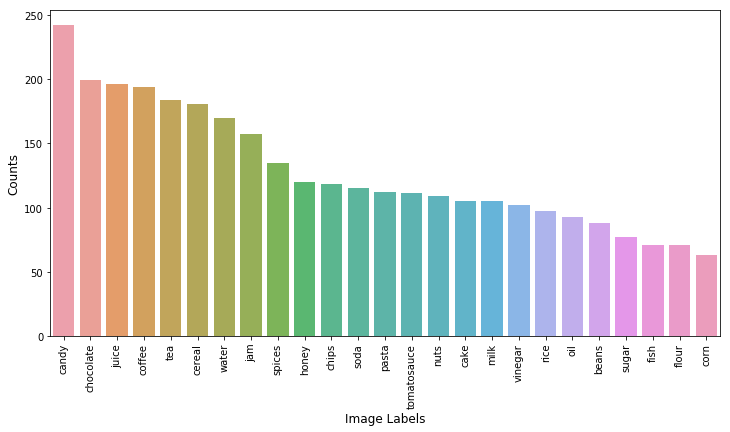

In [3]:
plt.figure(figsize = (12,6))
sns.barplot(label_counts.index, label_counts.values, alpha = 0.9)
plt.xticks(rotation = 'vertical')
plt.xlabel('Image Labels', fontsize =12)
plt.ylabel('Counts', fontsize = 12)
plt.show()

## Let's check the new distribution

In [14]:
train_dir = 'train2'

for dirpath, dirnames, filenames in os.walk(train_dir):
    i=0
    label=''
    for filename in [f for f in filenames if f.endswith(".jpg")]:
        label=os.path.split(dirpath)[1]
        i+=1
    print(label,i)
        

 0
water 666
chips 695
rice 659
juice 761
coffee 754
jam 618
chocolate 777
vinegar 600
candy 715
cake 614
corn 610
beans 601
cereal 710
fish 627
spices 655
oil 632
sugar 603
pasta 657
soda 678
flour 618
tea 716
tomatosauce 653
nuts 638
milk 621
honey 699
